# Когортный анализ
1. [Определение/загрузка нужных библиотек и данных](#Libraries)
1. [Первичный анализ Online Retail](#FirstStep)
1. [Когортный анализ](#Report)
1. [Анализ countries of the world](#Report1)

---
<a id="Libraries"></a>
## 1. Загрузка библиотек и данных 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import numpy as np

In [2]:
df = pd.read_excel('Online Retail.xlsx')

---
<a id="FirstStep"></a>
## 2. Первичный анализ Online Retail

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.dropna(subset=['CustomerID'], inplace=True)

In [6]:
df.CustomerID = df.CustomerID.astype('str')

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0


In [8]:
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()
n_orders 

CustomerID
12346.0     2
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     3
18283.0    16
18287.0     3
Name: InvoiceNo, Length: 4372, dtype: int64

In [9]:
mult_orders_perc = np.sum(n_orders > 1) / df['CustomerID'].nunique()
mult_orders_perc

0.69967978042086

In [10]:
print(f"{df['CustomerID'].nunique()} клиентов.")

4372 клиентов.


In [11]:
print(f"{df['InvoiceNo'].nunique()} заказов.")

22190 заказов.


In [12]:
print(f"{df.Quantity.sum()} ед. купленного товара.")

4906888 ед. купленного товара.


In [13]:
print(f'{100 * mult_orders_perc:.2f}% клиентов, заказывали более одного раза.')

69.97% клиентов, заказывали более одного раза.


In [14]:
print(f"{round(sum(df.Quantity*df.UnitPrice))} долл.США выручка.")

8300066 долл.США выручка.


## 3. Когортный анализ и визуализация<a id="Report"></a>

In [15]:
def cohort_fuc(list):
    df1 = df[df['Country'].isin(list)] 
    df1['order_month'] = df1['InvoiceDate'].dt.to_period('M')
    df1['cohort'] = df1.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')
    df_cohort = df1.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    return retention_matrix 
    

In [16]:
Country_United_Kingdom = cohort_fuc(['United Kingdom'])

<ipython-input-15-a8a5bf3afdb9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['order_month'] = df1['InvoiceDate'].dt.to_period('M')
<ipython-input-15-a8a5bf3afdb9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cohort'] = df1.groupby('CustomerID')['InvoiceDate'] \


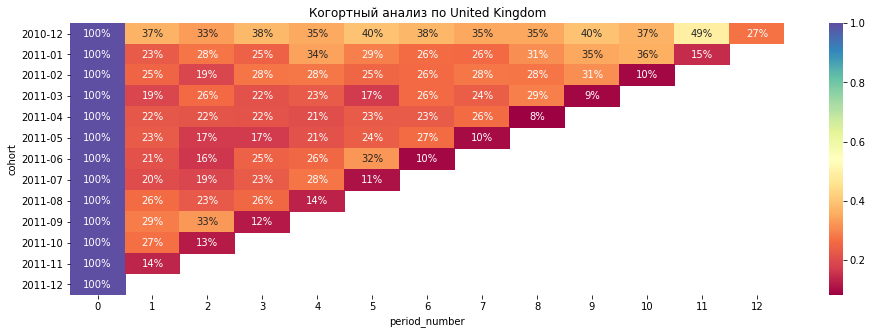

In [17]:
plt.figure(figsize=(16,5))
sns.heatmap(Country_United_Kingdom, fmt='.0%', annot=True, cmap='Spectral')
plt.title('Когортный анализ по United Kingdom')
plt.show()

In [18]:
Country=set(df['Country'].tolist())

In [19]:
Country_all = cohort_fuc(Country)

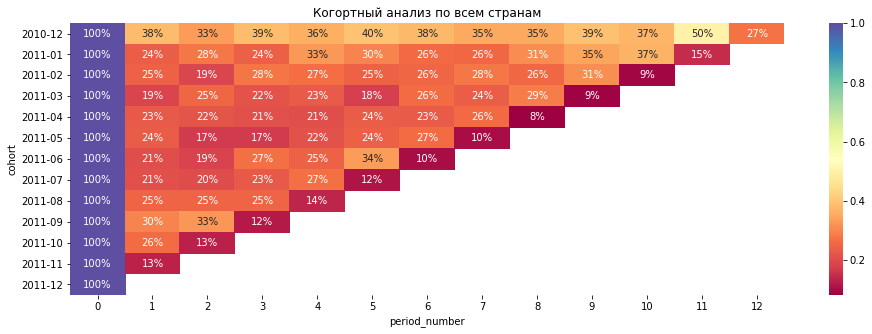

In [20]:
plt.figure(figsize=(16,5))
sns.heatmap(Country_all, fmt='.0%', annot=True, cmap='Spectral')
plt.title('Когортный анализ по всем странам')
plt.show()

### Вывод: как видно, на двух тепловых картах отсутствует значительная разница между общим когортным анализом и когортным анализом по стране :"United Kingdom" 

# 4. Анализ countries of the world<a id="Report1"></a>

In [100]:
dats = pd.read_csv('countries of the world.csv')

In [101]:
dats.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [102]:
dats.info() # смотрим информацию о типе данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

In [103]:
dats.dropna(inplace=True) # удаляем пропущенные значения

In [104]:
dats.iloc[:,3:20] = dats.iloc[:,3:20].replace(",",".", regex=True).astype(float) #изменяем тип данных

In [105]:
dats.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500.0,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748.0,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740.0,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
6,Anguilla,LATIN AMER. & CARIB,13477,102.0,132.1,59.80,10.76,21.03,8600.0,95.0,460.0,0.00,0.00,100.00,2.0,14.17,5.34,0.040,0.180,0.780
7,Antigua & Barbuda,LATIN AMER. & CARIB,69108,443.0,156.0,34.54,-6.15,19.46,11000.0,89.0,549.9,18.18,4.55,77.27,2.0,16.93,5.37,0.038,0.220,0.743


In [106]:
dats2=dats.groupby(['Region'])[['Pop. Density (per sq. mi.)']].mean()

In [107]:
dats2.reset_index(level=0, inplace=True)

In [108]:
dats2 #выводим среднее значения Pop. Density (per sq. mi.) по регионам

,Region,Pop. Density (per sq. mi.)
0,ASIA (EX. NEAR EAST),1352.003846
1,BALTICS,32.250000
2,C.W. OF IND. STATES,54.010000
3,EASTERN EUROPE,107.583333
4,LATIN AMER. & CARIB,141.202381
5,NEAR EAST,165.608333
6,NORTHERN AFRICA,51.600000
7,NORTHERN AMERICA,636.000000
8,OCEANIA,49.291667
9,SUB-SAHARAN AFRICA,87.231915


Делаем визуализацию

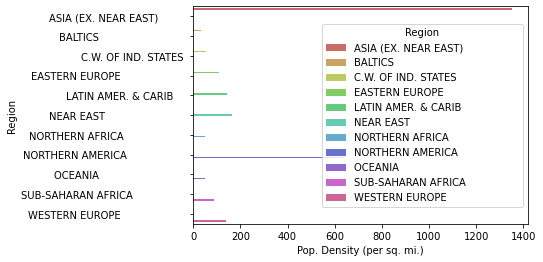

In [109]:
sns.barplot(x="Pop. Density (per sq. mi.)", y="Region", hue="Region",  palette='hls', data=dats2);

In [126]:
def max_counts_c(data): # делаем функцию (страны с максимальными показателями по каждой колонке)
    newDF = pd.DataFrame()
    for i in range(2,len(data.columns)):
        n=data.nlargest(1, data.columns[i])
        newDF=newDF.append(n, ignore_index = True)
    newDF.drop_duplicates()
    newDF.dropna(inplace=True)
    return newDF 

In [127]:
max_P= max_counts_c(dats)

In [128]:
max_P

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,China,ASIA (EX. NEAR EAST),1313973713,9596960.0,136.9,0.15,-0.40,24.18,5000.0,90.9,266.7,15.40,1.25,83.35,1.5,13.25,6.97,0.125,0.473,0.403
1,United States,NORTHERN AMERICA,298444215,9631420.0,31.0,0.21,3.41,6.50,37800.0,97.0,898.0,19.13,0.22,80.65,3.0,14.14,8.26,0.010,0.204,0.787
2,Macau,ASIA (EX. NEAR EAST),453125,28.0,16183.0,146.43,4.86,4.39,19400.0,94.5,384.9,0.00,0.00,100.00,2.0,8.48,4.47,0.001,0.072,0.927
3,"Micronesia, Fed. St.",OCEANIA,108004,702.0,153.9,870.66,-20.99,30.21,2000.0,89.0,114.8,5.71,45.71,48.58,2.0,24.68,4.75,0.289,0.152,0.559
4,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500.0,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
5,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500.0,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
6,Norway,WESTERN EUROPE,4610820,323802.0,14.2,7.77,1.74,3.70,37800.0,100.0,461.7,2.87,0.00,97.13,3.0,11.46,9.40,0.021,0.415,0.564
7,Australia,OCEANIA,20264082,7686850.0,2.6,0.34,3.98,4.69,29000.0,100.0,565.5,6.55,0.04,93.41,1.0,12.14,7.51,0.038,0.262,0.700
8,United States,NORTHERN AMERICA,298444215,9631420.0,31.0,0.21,3.41,6.50,37800.0,97.0,898.0,19.13,0.22,80.65,3.0,14.14,8.26,0.010,0.204,0.787
9,Bangladesh,ASIA (EX. NEAR EAST),147365352,144000.0,1023.4,0.40,-0.71,62.60,1900.0,43.1,7.3,62.11,3.07,34.82,2.0,29.80,8.27,0.199,0.198,0.603


 ### Вывод: сведения в данном датафрейме актуальны и соответствует мировым показателям, так например по Population на 1 месте China, больше всего чистой миграции в Afghanistan, ВВП на душу населения больше всех у United States, Norway

In [122]:
r = np.corrcoef(dats['GDP ($ per capita)'], dats['Infant mortality (per 1000 births)'])

In [123]:
r

array([[ 1.        , -0.63908984],
       [-0.63908984,  1.        ]])

### Вывод: В данных GDP ($ per capita) и Infant mortality (per 1000 births) сильная обратная зависимость

In [124]:
import scipy.stats

In [125]:
r, p = scipy.stats.pearsonr(dats['Pop. Density (per sq. mi.)'],dats['Net migration'])
print(f'Расчет коэффициента корреляции и p-value: {r} и {p} ')

Расчет коэффициента корреляции и p-value: 0.16170511563857723 и 0.030574789804598795 


### Вывод: коэффициент корреляции низкий (0,16), однако p-value<alpha(0,05), значит мы отвергаем  нулевую гипотезу